<a href="https://colab.research.google.com/github/cristhiamdaniel/PV-System/blob/main/Modelo-PV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importar librerias
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# Cargar los datos desde repositorio
!git clone https://github.com/cristhiamdaniel/PV-System.git

Cloning into 'PV-System'...
remote: Enumerating objects: 978, done.
remote: Counting objects: 100% (978/978), done.
remote: Compressing objects: 100% (975/975), done.
remote: Total 978 (delta 3), reused 972 (delta 2), pack-reused 0
Receiving objects: 100% (978/978), 1.02 MiB | 6.85 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [178]:
!git status

fatal: not a git repository (or any of the parent directories): .git


# Aproximacion Polinomica

## Aproximacion 1 Trozo

### Procesamiento datos

In [3]:
path = '/content/PV-System/Data_PV/'

Tomamos como ejemplo 1 solo archivo

In [106]:
g = 1000
t = 25
filename = f'OutputPV_T{t}_G{g}.txt'
df_aprox = pd.read_csv(path + filename, header=None)
df_aprox.columns = ['V_pv','I_pv']
df_aprox.insert(2,"P_pv",df_aprox["V_pv"]*df_aprox["I_pv"])
df_aprox.head()

,V_pv,I_pv,P_pv
0,0,28.030,0.000
1,1,28.028,28.028
2,2,28.026,56.052
3,3,28.024,84.072
4,4,28.023,112.092


### Curvas Caracteristicas

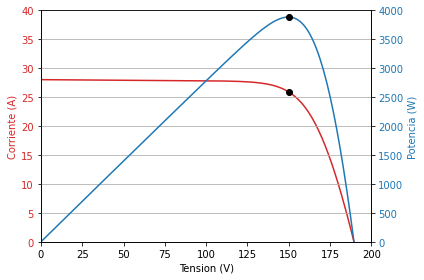

In [108]:
# Puntos de maxima potencia
def PMM():
    df_mask = df_aprox['P_pv']==df_aprox['P_pv'].max()
    filtered_df = df_aprox[df_mask]
    return filtered_df

pmm = PMM()


# Grafica Curvas caracteristicas
def curvaCaracteristica():
    global vpp, ipp, ppp
    v = df_aprox.V_pv
    i = df_aprox.I_pv
    p = df_aprox.P_pv
    vpp = pmm['V_pv']
    ipp = pmm['I_pv']
    ppp = pmm['P_pv']
    
    fig, ax1 = plt.subplots()
    
    color = "tab:red"
    ax1.set_xlabel("Tension (V)")
    ax1.set_ylabel("Corriente (A)", color=color)
    ax1.plot(v, i, color=color)
    ax1.plot(vpp, ipp, marker="o", color="black")
    ax1.tick_params(axis="y", labelcolor=color)
    ax1.set_xlim(0,200)
    ax1.set_ylim(0,40)
    ax2 = ax1.twinx() 
    
    color = "tab:blue"
    ax2.set_ylabel("Potencia (W)", color=color)  
    ax2.plot(v, p, color=color)
    ax2.plot(vpp, ppp, marker="o", color="black")
    ax2.tick_params(axis="y", labelcolor=color)
    ax2.set_xlim(0,200)
    ax2.set_ylim(0,4000)
    
    fig.tight_layout() 
    plt.grid()
  
    plt.show()

curvaCaracteristica()

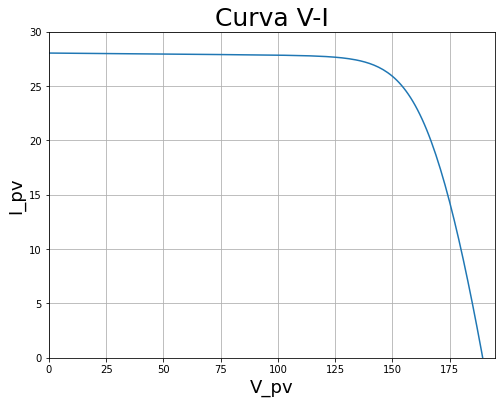

In [6]:
# Curva VI
x = df_aprox['V_pv']
y = df_aprox['I_pv']
fig = plt.figure(figsize=(8, 6))
plt.plot(x,y)
plt.title('Curva V-I',fontsize=25)
plt.xlabel("V_pv",fontsize=18)
plt.ylabel("I_pv",fontsize=18)
plt.xlim(0,195)
plt.ylim(0,30)
plt.grid()
plt.show()

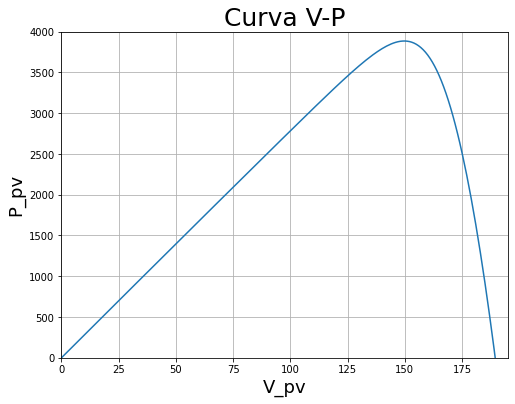

In [7]:
# Curva PV
df_aprox.insert(2,'P_pv',df_aprox['V_pv']*df_aprox['I_pv'])
x = df_aprox['V_pv']
y = df_aprox['P_pv']
fig = plt.figure(figsize=(8, 6))
plt.plot(x,y)
plt.title('Curva V-P',fontsize=25)
plt.xlabel("V_pv",fontsize=18)
plt.ylabel("P_pv",fontsize=18)
plt.xlim(0,195)
plt.ylim(0,4000)
plt.grid()
plt.show()

In [8]:
# Potencia maxima (W)
df_aprox['P_pv'].max()

3885.15

In [9]:
# Valores en el punto de maxima potencia
v_mpp = df_aprox[df_aprox['P_pv'] == 3881.448]
v_mpp

,V_pv,I_pv,P_pv
148,148,26.226,3881.448


### Modelo para Corriente

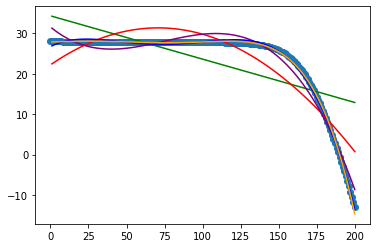

In [10]:
# Ajustamos la curva
#fit polynomial models up to degree 5
model1 = np.poly1d(np.polyfit(df_aprox.V_pv, df_aprox.I_pv, 1))
model2 = np.poly1d(np.polyfit(df_aprox.V_pv, df_aprox.I_pv, 2))
model3 = np.poly1d(np.polyfit(df_aprox.V_pv, df_aprox.I_pv, 3))
model4 = np.poly1d(np.polyfit(df_aprox.V_pv, df_aprox.I_pv, 4))
model5 = np.poly1d(np.polyfit(df_aprox.V_pv, df_aprox.I_pv, 5))

#create scatterplot
polyline = np.linspace(1, 200, 100)
plt.scatter(df_aprox.V_pv, df_aprox.I_pv)

#add fitted polynomial lines to scatterplot 
plt.plot(polyline, model1(polyline), color='green')
plt.plot(polyline, model2(polyline), color='red')
plt.plot(polyline, model3(polyline), color='purple')
plt.plot(polyline, model4(polyline), color='blue')
plt.plot(polyline, model5(polyline), color='orange')
plt.show()

In [12]:
#define function to calculate adjusted r-squared
def adjR(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))

    return results

for i in range(1,6):
  print(adjR(df_aprox.V_pv, df_aprox.I_pv, i))

{'r_squared': 0.4487414750626312}
{'r_squared': 0.804551084831346}
{'r_squared': 0.9625039074090337}
{'r_squared': 0.9969668207395768}
{'r_squared': 0.9986005415093702}


In [13]:
print(model5)

            5            4             3             2
-9.478e-10 x + 2.54e-07 x - 2.009e-05 x + 0.0003348 x + 0.008208 x + 27.9


In [37]:
def funcion_i(x):
    return -9.478e-10*x**5 + 2.54e-07*x**4 - 2.009e-05*x**3 + 0.0003348*x**2 + 0.008208*x + 27.9

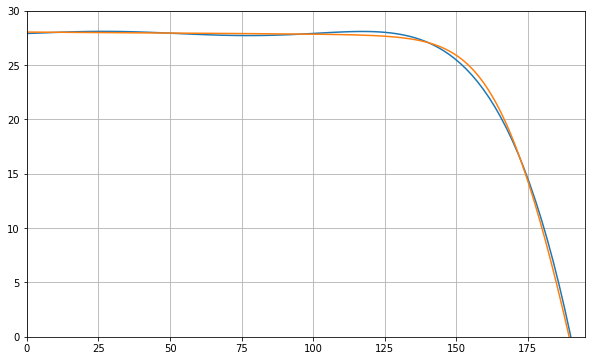

In [20]:
x = np.linspace(0,200,100)
y = funcion_i(x)
fig = plt.figure(figsize=(10, 6))
plt.plot(x,y)
plt.plot(df_aprox['V_pv'],df_aprox['I_pv'])
plt.xlim(0,195)
plt.ylim(0,30)
plt.grid()
plt.show()

### Modelo para Potencia


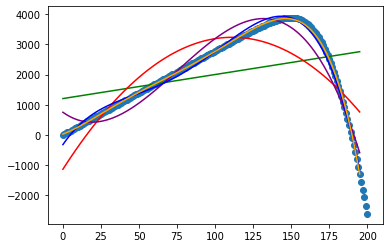

In [28]:
# Ajustamos la curva
#fit polynomial models up to degree 5

model1 = np.poly1d(np.polyfit(df_aprox.V_pv, df_aprox.P_pv, 1))
model2 = np.poly1d(np.polyfit(df_aprox.V_pv, df_aprox.P_pv, 2))
model3 = np.poly1d(np.polyfit(df_aprox.V_pv, df_aprox.P_pv, 3))
model4 = np.poly1d(np.polyfit(df_aprox.V_pv, df_aprox.P_pv, 4))
model5 = np.poly1d(np.polyfit(df_aprox.V_pv, df_aprox.P_pv, 5))

#create scatterplot
polyline = np.linspace(0, 195, 100)
plt.scatter(df_aprox.V_pv, df_aprox.P_pv)

#add fitted polynomial lines to scatterplot 
plt.plot(polyline, model1(polyline), color='green')
plt.plot(polyline, model2(polyline), color='red')
plt.plot(polyline, model3(polyline), color='purple')
plt.plot(polyline, model4(polyline), color='blue')
plt.plot(polyline, model5(polyline), color='orange')

plt.show()

In [29]:
#define function to calculate adjusted r-squared
def adjR(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))

    return results

for i in range(1,6):
  print(adjR(df_aprox.V_pv, df_aprox.P_pv, i))

{'r_squared': 0.10023753330243035}
{'r_squared': 0.655083100498483}
{'r_squared': 0.9222044750700639}
{'r_squared': 0.992327795258567}
{'r_squared': 0.9987608065441425}


In [30]:
print(model5)

            5             4           3          2
-2.892e-07 x + 9.628e-05 x - 0.01114 x + 0.5216 x + 19.24 x + 30.06


In [38]:
def funcion_p(x):
    return -2.892e-07*x**5 + 9.628e-05*x**4 - 0.01114*x**3 + 0.5216*x**2 + 19.24*x + 30.06

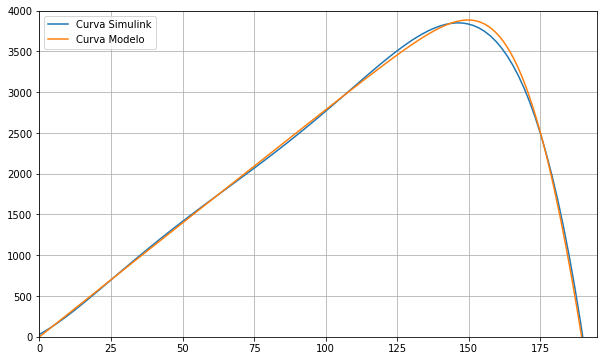

In [34]:
x = np.linspace(0,195,100)
y = funcion_p(x)
fig = plt.figure(figsize=(10, 6))
plt.plot(x,y,label="Curva Simulink")
plt.plot(df_aprox['V_pv'],df_aprox['P_pv'], label="Curva Modelo")
plt.legend()
plt.xlim(0,195)
plt.ylim(0,4000)
plt.grid()
plt.show()

### Error de prediccion

In [41]:
df_aprox['i_pred'] = funcion_i(df_aprox['V_pv'])
df_aprox['p_pred'] = funcion_p(df_aprox['V_pv'])


# Filtrar las filas cuyos valores de corriente es negativo

filtro = df_aprox['I_pv'] > 0
dataF = df_aprox[filtro]
dataF

,V_pv,I_pv,P_pv,i_pred,p_pred
0,0,28.03000,0.00000,27.900000,30.060000
1,1,28.02800,28.02800,27.908523,49.810556
2,2,28.02600,56.05200,27.917599,70.538811
3,3,28.02400,84.07200,27.927115,92.181348
4,4,28.02300,112.09200,27.936967,114.676992
...,...,...,...,...,...
185,185,4.96470,918.46950,5.809590,1014.954536
186,186,3.89300,724.09800,4.742009,823.809348
187,187,2.79980,523.56260,3.636145,624.026402
188,188,1.68570,316.91160,2.491038,415.366261


In [42]:
dataF['error_i'] = 100*(abs(dataF['I_pv'] - dataF['i_pred'])/dataF['I_pv'] )
dataF['error_p'] = 100*(abs(dataF['P_pv'] - dataF['p_pred'])/dataF['P_pv'] )
dataF

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,V_pv,I_pv,P_pv,i_pred,p_pred,error_i,error_p
0,0,28.03000,0.00000,27.900000,30.060000,0.463789,inf
1,1,28.02800,28.02800,27.908523,49.810556,0.426277,77.717126
2,2,28.02600,56.05200,27.917599,70.538811,0.386789,25.845307
3,3,28.02400,84.07200,27.927115,92.181348,0.345721,9.645718
4,4,28.02300,112.09200,27.936967,114.676992,0.307008,2.306134
...,...,...,...,...,...,...,...
185,185,4.96470,918.46950,5.809590,1014.954536,17.017944,10.504980
186,186,3.89300,724.09800,4.742009,823.809348,21.808604,13.770422
187,187,2.79980,523.56260,3.636145,624.026402,29.871614,19.188499
188,188,1.68570,316.91160,2.491038,415.366261,47.774674,31.066916


In [47]:
dataF2 = dataF.drop(dataF.index[0])
dataF2

,V_pv,I_pv,P_pv,i_pred,p_pred,error_i,error_p
1,1,28.02800,28.02800,27.908523,49.810556,0.426277,77.717126
2,2,28.02600,56.05200,27.917599,70.538811,0.386789,25.845307
3,3,28.02400,84.07200,27.927115,92.181348,0.345721,9.645718
4,4,28.02300,112.09200,27.936967,114.676992,0.307008,2.306134
5,5,28.02100,140.10500,27.947055,137.966771,0.263893,1.526162
...,...,...,...,...,...,...,...
185,185,4.96470,918.46950,5.809590,1014.954536,17.017944,10.504980
186,186,3.89300,724.09800,4.742009,823.809348,21.808604,13.770422
187,187,2.79980,523.56260,3.636145,624.026402,29.871614,19.188499
188,188,1.68570,316.91160,2.491038,415.366261,47.774674,31.066916


(array([183.,   3.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([3.55117037e-03, 1.36762113e+01, 2.73488714e+01, 4.10215315e+01,
        5.46941916e+01, 6.83668518e+01, 8.20395119e+01, 9.57121720e+01,
        1.09384832e+02, 1.23057492e+02, 1.36730152e+02]),
 <a list of 10 Patch objects>)

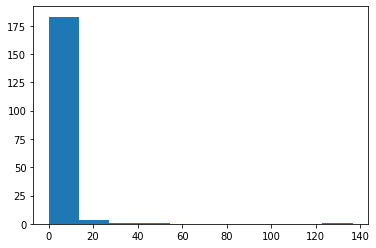

In [50]:
plt.hist(dataF2['error_i'])

(array([181.,   3.,   2.,   1.,   0.,   0.,   0.,   0.,   1.,   1.]),
 array([4.36244993e-03, 8.95789172e+00, 1.79114210e+01, 2.68649503e+01,
        3.58184795e+01, 4.47720088e+01, 5.37255381e+01, 6.26790673e+01,
        7.16325966e+01, 8.05861259e+01, 8.95396551e+01]),
 <a list of 10 Patch objects>)

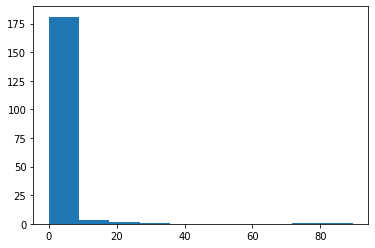

In [51]:
plt.hist(dataF2['error_p'])

## Aproximacion por 2 trozos

In [109]:
# Puntos de maxima potencia
def PMM():
    df_mask = df_aprox['P_pv']==df_aprox['P_pv'].max()
    filtered_df = dataF2[df_mask]
    return filtered_df

pmm = PMM()
print(pmm)

     V_pv    I_pv     P_pv     i_pred    p_pred   error_i   error_p
150   150  25.901  3885.15  25.474388  3835.185  1.647089  1.286051


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [110]:
# Funcion para obtener el indice del PMM
def index_pmm():
    pmm = PMM()
    index = pmm.index.values[0]
    return index

In [55]:
# funcion para calcular el modelo de la curva ajustada
def model(x,y,degree):
    model = np.poly1d(np.polyfit(x, y, degree))
    return model

In [56]:
# Funcion para calcular el R-cuadrado ajustado
def adjR(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))

    return results

In [113]:
i = index_pmm()

rangos = [10, 20, 30, 40, 50]
grados = [3,5,7]
model1 = []
model2 = []
r2_1 = []
r2_2 = []

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [114]:
for g in grados:
    for r in rangos:   
        df1 = df_aprox.iloc[:i+r]
        df2 = df_aprox.iloc[i-r:]
        
        v1 = df1.V_pv
        p1 = df1.P_pv
        v2 = df2.V_pv
        p2 = df2.P_pv
           
        m1 = model(v1,p1,g)
        m2 = model(v2,p2,g)
            
        model1.append(m1)
        model2.append(m2)
        
        ad1 = adjR(v1, p1, g)
        ad2 = adjR(v2, p2, g)
        
        r2_1.append(ad1)
        r2_2.append(ad2)

In [115]:
for i in range(5):
  print(model1[i])

            3          2
-0.0006964 x + 0.1293 x + 21.61 x + 62.03
           3          2
-0.001379 x + 0.2734 x + 13.75 x + 146.4
           3          2
-0.002371 x + 0.4955 x + 0.9131 x + 292.6
           3          2
-0.003537 x + 0.7711 x - 15.92 x + 495.4
           3         2
-0.004682 x + 1.057 x - 34.3 x + 728.7


In [127]:
def p1_1(x):
    return -0.0006964*x**3 + 0.1293*x**2 + 21.61*x + 62.03
def p1_2(x):
    return -0.001379*x**3 + 0.2734*x**2 + 13.75*x + 146.4
def p1_3(x):
    return -0.002371*x**3 + 0.4955*x**2 + 0.9131*x + 292.6
def p1_4(x):
    return -0.003537*x**3 + 0.7711*x**2 - 15.92*x + 495.4
def p1_5(x):
    return -0.004682*x**3 + 1.057*x**2 - 34.3*x + 728.7


In [128]:
for i in range(5,10):
  print(model1[i])

            5             4            3          2
-1.715e-07 x + 5.636e-05 x - 0.006563 x + 0.3175 x + 22.23 x + 23.21
            5             4           3          2
-2.794e-07 x + 9.657e-05 x - 0.01183 x + 0.6039 x + 16.44 x + 49
            5           4           3          2
-3.642e-07 x + 0.00013 x - 0.01646 x + 0.8703 x + 10.74 x + 75.89
            5             4         3          2
-3.739e-07 x + 0.0001339 x - 0.017 x + 0.9019 x + 10.06 x + 79.15
            5             4           3          2
-3.001e-07 x + 0.0001012 x - 0.01193 x + 0.5738 x + 17.95 x + 37.08


In [129]:
def p1_6(x):
    return -1.715e-07*x*5 + 5.636e-05*x**4 - 0.006563*x**3 + 0.3175*x**2 + 22.23*x + 23.21
def p1_7(x):
    return -2.794e-07*x*5 + 9.657e-05*x**4 - 0.01183*x**3 + 0.6039*x**2 + 16.44*x + 49
def p1_8(x):
    return -3.642e-07*x*5 + 0.00013*x**4 - 0.01646*x**3 + 0.8703*x**2 + 10.74*x + 75.89
def p1_9(x):
    return -3.739e-07*x*5 + 0.0001339*x**4 - 0.017*x**3 + 0.9019*x**2+ 10.06*x + 79.15
def p1_10(x):
    return -3.001e-07*x*5 + 0.0001012*x**4- 0.01193*x**3 + 0.5738*x**2 + 17.95*x + 37.08

In [130]:
for i in range(10,15):
  print(model1[i])

            7             6            5             4            3
-2.192e-11 x + 1.007e-08 x - 1.84e-06 x + 0.0001687 x - 0.008076 x
           2
 + 0.1878 x + 26.24 x + 3.749
            7            6             5             4            3
-2.204e-11 x + 1.01e-08 x - 1.838e-06 x + 0.0001677 x - 0.007979 x
           2
 + 0.1841 x + 26.29 x + 3.595
            7             6             5             4            3
-6.162e-12 x + 1.034e-09 x + 1.973e-07 x - 5.978e-05 x + 0.005209 x
           2
 - 0.1891 x + 30.53 x - 7.154
           7             6             5             4           3
1.964e-11 x - 1.448e-08 x + 3.864e-06 x - 0.0004913 x + 0.03155 x
           2
 - 0.9743 x + 39.93 x - 32.37
           7             6             5             4           3
3.957e-11 x - 2.706e-08 x + 6.992e-06 x - 0.0008783 x + 0.05639 x
          2
 - 1.753 x + 49.74 x - 60.14


In [131]:
def p1_11(x):
    return -2.192e-11*x**7 + 1.007e-08*x**6 - 1.84e-06*x**5 + 0.0001687*x**4 - 0.008076*x**3 + 0.1878*x**2 + 26.24*x + 3.749
def p1_12(x):
    return -2.204e-11*x**7 + 1.01e-08*x**6 - 1.838e-06*x**5 + 0.0001677*x**4 - 0.007979*x**3 + 0.1841*x**2 + 26.29*x + 3.595
def p1_13(x):
    return -6.162e-12*x**7 + 1.034e-09*x**6 + 1.973e-07*x**5 - 5.978e-05*x**4 + 0.005209*x**3 - 0.1891*x**2 + 30.53*x - 7.154
def p1_14(x):
    return 1.964e-11*x**7 - 1.448e-08*x**6 + 3.864e-06*x**5 - 0.0004913*x**4 + 0.03155*x**3  - 0.9743*x**2 + 39.93*x - 32.37
def p1_15(x):
    return 3.957e-11*x**7 - 2.706e-08*x**6 + 6.992e-06*x**5 - 0.0008783*x**4 + 0.05639*x**3  - 1.753*x**2 + 49.74*x - 60.14


In [125]:
v_max = 150
p_max = 3885.15
def error(a):
    return round(((abs(a - p_max))/p_max)*100,2)

In [126]:
print("Error modelo 1: ", error(p1_1(v_max)))
print("Error modelo 2: ", error(p1_2(v_max)))
print("Error modelo 3: ", error(p1_3(v_max)))
print("Error modelo 4: ", error(p1_4(v_max)))
print("Error modelo 5: ", error(p1_5(v_max)))
print("Error modelo 6: ", error(p1_6(v_max)))
print("Error modelo 7: ", error(p1_7(v_max)))
print("Error modelo 8: ", error(p1_8(v_max)))
print("Error modelo 9: ", error(p1_9(v_max)))
print("Error modelo 10: ", error(p1_10(v_max)))
print("Error modelo 11: ", error(p1_11(v_max)))
print("Error modelo 12: ", error(p1_12(v_max)))
print("Error modelo 13: ", error(p1_13(v_max)))
print("Error modelo 14: ", error(p1_14(v_max)))
print("Error modelo 15: ", error(p1_15(v_max)))

Error modelo 1:  0.58
Error modelo 2:  4.6
Error modelo 3:  7.95
Error modelo 4:  9.4
Error modelo 5:  8.25
Error modelo 6:  334.57
Error modelo 7:  545.15
Error modelo 8:  711.52
Error modelo 9:  731.18
Error modelo 10:  584.89
Error modelo 11:  1.18
Error modelo 12:  0.31
Error modelo 13:  0.48
Error modelo 14:  1.19
Error modelo 15:  2.16


In [134]:
for i in range(5):
  print(model2[i])

          3         2
-0.01369 x + 4.199 x - 334.8 x + 5885
          3         2
-0.01903 x + 6.961 x - 808.3 x + 3.278e+04
          3         2
-0.02122 x + 8.063 x - 992.4 x + 4.294e+04
          3         2
-0.02109 x + 8.004 x - 983.2 x + 4.247e+04
          3         2
-0.01966 x + 7.322 x - 876.3 x + 3.698e+04


In [135]:
def p2_1(x):
    return -0.01369*x**3 + 4.199*x**2 - 334.8*x + 5885
def p2_2(x):
    return -0.01903*x**3 + 6.961*x**2 - 808.3*x + 3.278e+04
def p2_3(x):
    return -0.02122*x**3 + 8.063*x**2 - 992.4*x + 4.294e+04
def p2_4(x):
    return -0.02109*x**3 + 8.004*x**2 - 983.2*x + 4.247e+04
def p2_5(x):
    return -0.01966*x**3 + 7.322*x**2 - 876.3*x + 3.698e+04


In [136]:
for i in range(5,10):
  print(model2[i])

           5             4          3         2
4.294e-07 x + 3.297e-05 x - 0.1607 x + 52.02 x - 6293 x + 2.703e+05
           5            4          3         2
3.872e-06 x - 0.002906 x + 0.8394 x - 117.5 x + 8024 x - 2.115e+05
           5            4         3         2
4.948e-06 x - 0.003803 x + 1.137 x - 166.6 x + 1.206e+04 x - 3.432e+05
           5            4         3         2
4.437e-06 x - 0.003392 x + 1.006 x - 145.9 x + 1.043e+04 x - 2.925e+05
           5            4          3         2
3.332e-06 x - 0.002526 x + 0.7369 x - 104.5 x + 7275 x - 1.974e+05


In [137]:
def p2_6(x):
    return 4.294e-07*x**5 + 3.297e-05*x**4 - 0.1607*x**3 + 52.02*x**2 - 6293*x + 2.703e+05
def p2_7(x):
    return 3.872e-06*x**5 - 0.002906*x**4 + 0.8394*x**3 - 117.5*x**2 + 8024*x - 2.115e+05
def p2_8(x):
    return 4.948e-06*x**5 - 0.003803*x**4 + 1.137*x**3 - 166.6*x**2 + 1.206e+04*x - 3.432e+05
def p2_9(x):
    return 4.437e-06*x**5 - 0.003392*x**4 + 1.006*x**3 - 145.9*x**2 + 1.043e+04*x - 2.925e+05
def p2_10(x):
    return 3.332e-06*x**5 - 0.002526*x**4 + 0.7369*x**3 - 104.5*x**2 + 7275*x - 1.974e+05

In [138]:
for i in range(10,15):
  print(model2[i])

           7            6             5          4         3        2
1.058e-09 x - 1.41e-06 x + 0.0007947 x - 0.2457 x + 44.99 x - 4881 x + 2.906e+05 x - 7.331e+06
            7             6             5          4         3        2
-1.189e-09 x + 1.264e-06 x - 0.0005647 x + 0.1373 x - 19.59 x + 1635 x - 7.367e+04 x + 1.374e+06
            7         6             5          4         3        2
-1.823e-09 x + 2e-06 x - 0.0009302 x + 0.2377 x - 36.08 x + 3254 x - 1.617e+05 x + 3.416e+06
            7             6             5          4         3        2
-1.389e-09 x + 1.514e-06 x - 0.0006982 x + 0.1765 x - 26.45 x + 2351 x - 1.148e+05 x + 2.38e+06
            7             6             5          4         3        2
-7.425e-10 x + 8.093e-07 x - 0.0003711 x + 0.0928 x - 13.68 x + 1190 x - 5.659e+04 x + 1.139e+06


In [139]:
def p2_11(x):
    return 1.058e-09*x**7 - 1.41e-06*x**6 + 0.0007947*x**5 - 0.2457*x**4 + 44.99*x**3 - 4881*x**2 + 2.906e+05*x - 7.331e+06
def p2_12(x):
    return -1.189e-09*x**7 + 1.264e-06*x**6 - 0.0005647*x**5 + 0.1373*x**4 - 19.59*x**3 + 1635*x**2 - 7.367e+04*x + 1.374e+06
def p2_13(x):
    return -1.823e-09*x**7 + 2e-06*x**6 - 0.0009302*x**5 + 0.2377*x**4 - 36.08*x**3 + 3254*x**2 - 1.617e+05*x + 3.416e+06
def p2_14(x):
    return -1.389e-09*x**7 + 1.514e-06*x**6 - 0.0006982*x**5 + 0.1765*x**4 - 26.45*x**3 + 2351*x**2 - 1.148e+05*x + 2.38e+06
def p2_15(x):
    return -7.425e-10*x**7 + 8.093e-07*x**6 - 0.0003711*x**5 + 0.0928*x**4 - 13.68*x**3 + 1190*x**2 - 5.659e+04*x + 1.139e+06


In [140]:
print("Error modelo 1: ", error(p2_1(v_max)))
print("Error modelo 2: ", error(p2_2(v_max)))
print("Error modelo 3: ", error(p2_3(v_max)))
print("Error modelo 4: ", error(p2_4(v_max)))
print("Error modelo 5: ", error(p2_5(v_max)))
print("Error modelo 6: ", error(p2_6(v_max)))
print("Error modelo 7: ", error(p2_7(v_max)))
print("Error modelo 8: ", error(p2_8(v_max)))
print("Error modelo 9: ", error(p2_9(v_max)))
print("Error modelo 10: ", error(p2_10(v_max)))
print("Error modelo 11: ", error(p2_11(v_max)))
print("Error modelo 12: ", error(p2_12(v_max)))
print("Error modelo 13: ", error(p2_13(v_max)))
print("Error modelo 14: ", error(p2_14(v_max)))
print("Error modelo 15: ", error(p2_15(v_max)))

Error modelo 1:  1.38
Error modelo 2:  1.19
Error modelo 3:  0.13
Error modelo 4:  0.41
Error modelo 5:  1.09
Error modelo 6:  3.84
Error modelo 7:  7.91
Error modelo 8:  32.43
Error modelo 9:  9.0
Error modelo 10:  0.29
Error modelo 11:  445.75
Error modelo 12:  429.44
Error modelo 13:  845.25
Error modelo 14:  242.03
Error modelo 15:  26.01


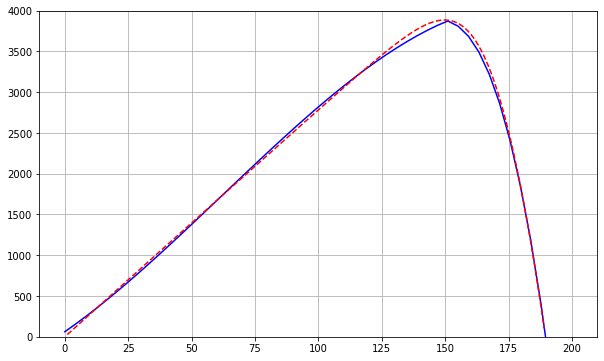

In [142]:
x = np.linspace(0, 200)
y = np.piecewise(x, [ (x < v_max) & (x >= 0), (x <= 200) & (x >= v_max)], [lambda x: p1_1(x), lambda x: p2_3(x)])
fig = plt.figure(figsize=(10, 6))
plt.plot(x, y, "b-")
plt.plot(dataF2.V_pv,dataF2.P_pv,"r--")
plt.ylim(0,4000)
plt.grid()
plt.show()

In [144]:
df_trozo1 = df_aprox[:v_max]
df_trozo1.head()

,V_pv,I_pv,P_pv
0,0,28.030,0.000
1,1,28.028,28.028
2,2,28.026,56.052
3,3,28.024,84.072
4,4,28.023,112.092


In [151]:
df_trozo1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V_pv    150 non-null    int64  
 1   I_pv    150 non-null    float64
 2   P_pv    150 non-null    float64
 3   P1      150 non-null    float64
 4   P2      150 non-null    float64
 5   P3      150 non-null    float64
 6   P4      150 non-null    float64
 7   P5      150 non-null    float64
 8   P6      150 non-null    float64
 9   P7      150 non-null    float64
 10  P8      150 non-null    float64
 11  P9      150 non-null    float64
 12  P10     150 non-null    float64
 13  P11     150 non-null    float64
 14  P12     150 non-null    float64
 15  P13     150 non-null    float64
 16  P14     150 non-null    float64
 17  P15     150 non-null    float64
dtypes: float64(17), int64(1)
memory usage: 21.2 KB


In [ ]:
df_trozo1['P1'] = p1_1(df_trozo1['V_pv'])
df_trozo1['P2'] = p1_2(df_trozo1['V_pv'])
df_trozo1['P3'] = p1_3(df_trozo1['V_pv'])
df_trozo1['P4'] = p1_4(df_trozo1['V_pv'])
df_trozo1['P5'] = p1_5(df_trozo1['V_pv'])
df_trozo1['P6'] = p1_6(df_trozo1['V_pv'])
df_trozo1['P7'] = p1_7(df_trozo1['V_pv'])
df_trozo1['P8'] = p1_8(df_trozo1['V_pv'])
df_trozo1['P9'] = p1_9(df_trozo1['V_pv'])
df_trozo1['P10'] = p1_10(df_trozo1['V_pv'])
df_trozo1['P11'] = p1_11(df_trozo1['V_pv'])
df_trozo1['P12'] = p1_12(df_trozo1['V_pv'])
df_trozo1['P13'] = p1_13(df_trozo1['V_pv'])
df_trozo1['P14'] = p1_14(df_trozo1['V_pv'])
df_trozo1['P15'] = p1_15(df_trozo1['V_pv'])
df_trozo1.head()

In [164]:
def error_medio(x):
  error = []
  for i in range(150):
    real = df_trozo1.iloc[i]['P_pv']
    aprox = df_trozo1.iloc[i][x]
    if real != 0:
      e = 100*(abs(real-aprox)/real)
      error.append(e)
  media = np.mean(error)
  std = np.std(error)
  return print(f"El promedio de error de {x} es: ", media, "y la desv est: ", std)


In [165]:
for i in range(1,16):
  x = f'P{i}'
  error_medio(x)

El promedio de error de P1 es:  4.443110812745671 y la desv est:  18.311853896085776
El promedio de error de P2 es:  10.463468289946828 y la desv est:  43.66436605063006
El promedio de error de P3 es:  20.784303272636233 y la desv est:  88.0258033810762
El promedio de error de P4 es:  35.12739523176626 y la desv est:  150.08056217798506
El promedio de error de P5 es:  51.82989483539773 y la desv est:  221.9682704290052
El promedio de error de P6 es:  63.91243728011967 y la desv est:  84.22111092870475
El promedio de error de P7 es:  104.70262848380658 y la desv est:  137.1865982644151
El promedio de error de P8 es:  137.12837540176614 y la desv est:  178.84893043599263
El promedio de error de P9 es:  141.01780212115304 y la desv est:  183.78084769334106
El promedio de error de P10 es:  111.66998591553178 y la desv est:  147.59393374218874
El promedio de error de P11 es:  0.33692577136356094 y la desv est:  0.672531678049347
El promedio de error de P12 es:  0.1988729411125218 y la desv 

In [166]:
df_trozo2 = df_aprox[v_max-1:]
df_trozo2.head()

,V_pv,I_pv,P_pv
149,149,26.070,3884.430
150,150,25.901,3885.150
151,151,25.716,3883.116
152,152,25.516,3878.432
153,153,25.298,3870.594


In [167]:
df_trozo2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 149 to 200
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V_pv    52 non-null     int64  
 1   I_pv    52 non-null     float64
 2   P_pv    52 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.3 KB


In [ ]:
df_trozo2['P1'] = p2_1(df_trozo2['V_pv'])
df_trozo2['P2'] = p2_2(df_trozo2['V_pv'])
df_trozo2['P3'] = p2_3(df_trozo2['V_pv'])
df_trozo2['P4'] = p2_4(df_trozo2['V_pv'])
df_trozo2['P5'] = p2_5(df_trozo2['V_pv'])
df_trozo2['P6'] = p2_6(df_trozo2['V_pv'])
df_trozo2['P7'] = p2_7(df_trozo2['V_pv'])
df_trozo2['P8'] = p2_8(df_trozo2['V_pv'])
df_trozo2['P9'] = p2_9(df_trozo2['V_pv'])
df_trozo2['P10'] = p2_10(df_trozo2['V_pv'])
df_trozo2['P11'] = p2_11(df_trozo2['V_pv'])
df_trozo2['P12'] = p2_12(df_trozo2['V_pv'])
df_trozo2['P13'] = p2_13(df_trozo2['V_pv'])
df_trozo2['P14'] = p2_14(df_trozo2['V_pv'])
df_trozo2['P15'] = p2_15(df_trozo2['V_pv'])

In [174]:
def error_medio(x):
  error = []
  for i in range(52):
    real = df_trozo2.iloc[i]['P_pv']
    aprox = df_trozo2.iloc[i][x]
    if real != 0:
      e = 100*(abs(real-aprox)/real)
      error.append(e)
  media = np.mean(error)
  std = np.std(error)
  return print(f"El promedio de error de {x} es: ", media, "y la desv est: ", std)

In [175]:
for i in range(1,16):
  x = f'P{i}'
  error_medio(x)

El promedio de error de P1 es:  0.6782335437069752 y la desv est:  13.934783712081389
El promedio de error de P2 es:  0.9592383081723503 y la desv est:  16.296840262700986
El promedio de error de P3 es:  0.7963943879048487 y la desv est:  5.525462443037723
El promedio de error de P4 es:  1.0114292409996104 y la desv est:  12.896275124152885
El promedio de error de P5 es:  0.8669605508183522 y la desv est:  14.402685050618343
El promedio de error de P6 es:  3.758419256767813 y la desv est:  55.85016902868651
El promedio de error de P7 es:  7.788328083792328 y la desv est:  96.02148247434856
El promedio de error de P8 es:  31.001443609290398 y la desv est:  356.2150592896234
El promedio de error de P9 es:  8.761919648272869 y la desv est:  125.08740996477384
El promedio de error de P10 es:  0.15831229133181715 y la desv est:  7.622208635624573
El promedio de error de P11 es:  439.88713318990693 y la desv est:  6916.984251804879
El promedio de error de P12 es:  443.8343975363483 y la desv

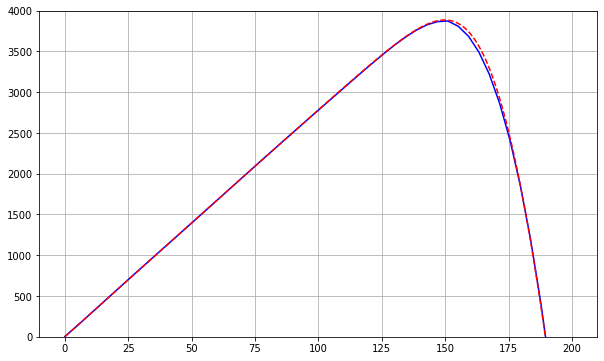

In [177]:
x = np.linspace(0, 200)
y = np.piecewise(x, [ (x < v_max) & (x >= 0), (x <= 200) & (x >= v_max)], [lambda x: p1_12(x), lambda x: p2_3(x)])
fig = plt.figure(figsize=(10, 6))
plt.plot(x, y, "b-")
plt.plot(df_aprox.V_pv,df_aprox.P_pv,"r--")
plt.ylim(0,4000)
plt.grid()
plt.show()

# Modelo de Red Neuronal para un Arreglo PV

Los datos entregados por el modelo ```Sunset.slx``` corresponden a 961 archivos iterados de la siguiente manera: 31 temperaturas ```T=[15-45]``` con un $\Delta$ T = 1. Y 31 irradiancias ```G=[400-1000]``` con un $\Delta$ G = 20.

Cada archivo esta nombrado de la siguiente manera: ```Outputpv_T{T}_G{G}.txt``` que contienen los calculos obtenidos por simulink: La variacion de la corriente con respecto a la tension para una temperatura e irradiancia determinada.

La tension varia de 0 a 200 V con un $\Delta$ V = 1.

## Procesamiento de Datos

### Data Potencia Maxima

In [4]:
# Creacion de un dataframe general con la maxima potencia para cada T y G

path = '/content/PV-System/Data_PV/'

# Iteramos en los archivos para extraer la maxima potencia
pot_max = []
irra = []
temp = []
for t in range(15,45+1):
  for g in range(400,1000+1,20):
    filename = f'OutputPV_T{t}_G{g}.txt'
    df = pd.read_csv(path + filename, header=None)
    encabezado = ["V", "I"]
    df.columns = encabezado
    df['P'] = df['V'] * df['I']
    pmm = df['P'].max()
    pot_max.append(pmm)
    irra.append(g)
    temp.append(t)

# Creacion del DF

dataframe_pot = pd.DataFrame()
dataframe_pot['T'] = temp
dataframe_pot['G'] = irra
dataframe_pot['Pmax'] = pot_max
dataframe_pot

,T,G,Pmax
0,15,400,1582.992
1,15,420,1666.400
2,15,440,1749.760
3,15,460,1832.985
4,15,480,1916.222
...,...,...,...
956,45,920,3225.292
957,45,940,3294.253
958,45,960,3363.087
959,45,980,3431.794


In [ ]:
dataframe_pot.info()

In [ ]:
# Guardar el archivo local
dataframe_pot.to_csv('Data_pot.csv')

### Data Potencia: Entrenamiento - Validacion 

In [ ]:
train_1, test_1 = train_test_split(dataframe_pot, test_size = 0.30)
train_1.to_csv('train_pot.csv')
test_1.to_csv('test_pot.csv')

## Modelo 1 - Potencia Max

### RNA 1

Vamos a predecir la ```potencia maxima``` teniendo como entrada la ```temperatura``` y la ```irradiancia```.

In [ ]:
g = train_1['G']
t = train_1['T']

entrada = np.array(np.column_stack((g,t)), dtype='float')

p = train_1['Pmax']
salida = np.array(np.transpose(p), dtype='float')

In [ ]:
oculta1 = tf.keras.layers.Dense(units=10, input_shape=[2])
oculta2 = tf.keras.layers.Dense(units=10)
output = tf.keras.layers.Dense(units=1)
modelo = tf.keras.Sequential([oculta1,  oculta2, output])

In [ ]:
modelo.compile(
    optimizer = tf.keras.optimizers.Adam(0.1),
    loss = 'mean_squared_error'
)

In [ ]:
print("Comenzando entrettnamiento ... ")
historial = modelo.fit(entrada,salida, epochs=100, verbose=False)
print("Modelo entranado!")

Comenzando entrettnamiento ... 
Modelo entranado!


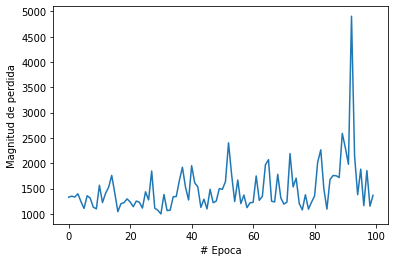

In [ ]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

### RNA 2

Comenzando entrenamiento ... 
Modelo entranado!


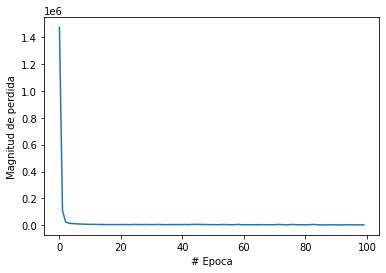

In [ ]:
g = train_1['G']
t = train_1['T']

entrada = np.array(np.column_stack((g,t)), dtype='float')

p = train_1['Pmax']

##############################################################

salida = np.array(np.transpose(p), dtype='float')
oculta1 = tf.keras.layers.Dense(units=5, input_shape=[2])
oculta2 = tf.keras.layers.Dense(units=2)
output = tf.keras.layers.Dense(units=1)

###############################################################
modelo = tf.keras.Sequential([oculta1,  oculta2, output])
###############################################################

modelo.compile(
    optimizer = tf.keras.optimizers.Adam(0.1),
    loss = 'mean_squared_error'
)
###############################################################

print("Comenzando entrenamiento ... ")
historial = modelo.fit(entrada,salida, epochs=100, verbose=False)
print("Modelo entranado!")
###############################################################
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

In [ ]:
print("Variables internas del modelo")
print(oculta1.get_weights())
print(oculta2.get_weights())
print(output.get_weights())

Variables internas del modelo
[array([[ 0.67033446, -0.2966106 , -0.01998537, -0.38660145,  1.0487925 ],
       [-1.075884  , -0.20943986, -3.1135402 ,  0.02758573, -1.84972   ]],
      dtype=float32), array([ 18.468002 ,   1.2586317,  27.301346 , -10.97803  ,  20.440323 ],
      dtype=float32)]
[array([[-0.17117049, -1.2795218 ],
       [-0.31654954, -0.09632481],
       [-0.6963905 , -0.80916595],
       [ 0.03652098,  0.593637  ],
       [-0.32155666, -1.7501591 ]], dtype=float32), array([ -2.9189575, -16.129646 ], dtype=float32)]
[array([[-0.08504742],
       [-1.3637999 ]], dtype=float32), array([15.210299], dtype=float32)]


In [ ]:
# Modelo
w1 = np.array([[ 0.67033446, -0.2966106 , -0.01998537, -0.38660145,  1.0487925 ],
       [-1.075884  , -0.20943986, -3.1135402 ,  0.02758573, -1.84972   ]],
      dtype='float')
b1 = np.array([ 18.468002 ,   1.2586317,  27.301346 , -10.97803  ,  20.440323 ],
      dtype='float')
w2 = np.array([[-0.17117049, -1.2795218 ],
       [-0.31654954, -0.09632481],
       [-0.6963905 , -0.80916595],
       [ 0.03652098,  0.593637  ],
       [-0.32155666, -1.7501591 ]], dtype='float')
b2 = np.array([ -2.9189575, -16.129646 ], dtype='float')
w3 = np.array([[-0.08504742],
       [-1.3637999 ]], dtype='float')
b3 = np.array([15.210299], dtype='float')

In [ ]:
test_1.head()

,T,G,Pmax
901,44,440,1529.080
710,37,960,3521.040
439,29,500,1890.510
800,40,900,3249.988
869,43,420,1464.832


In [ ]:
test_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 901 to 521
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       289 non-null    int64  
 1   G       289 non-null    int64  
 2   Pmax    289 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 9.0 KB


In [ ]:
# VALIDACION 

pot_pred = []  # Prediccion de Potencias maximas 
errorAb = [] # Error absoluto de cada prediccion

for i in range(289):
  G = test_1.iloc[i]['G']
  T = test_1.iloc[i]['T']
  entrada = np.array([[G,T]], dtype='float')
  x1 = entrada.dot(w1) + b1
  x2 = x1.dot(w2) + b2
  x3 = x2.dot(w3) + b3
  pot_pred.append(float(x3))

for i in range(289):
  error = 100*(abs(test_1.iloc[i]['Pmax'] - pot_pred[i])/test_1.iloc[i]['Pmax'])
  errorAb.append(error)

test_1["Pot Pred"] = pot_pred
test_1["Error %"] = errorAb

test_1

,T,G,Pmax,Pot Pred,Error %
901,44,440,1529.080,1459.069590,4.578597
710,37,960,3521.040,3586.179800,1.850016
439,29,500,1890.510,1846.919587,2.305749
800,40,900,3249.988,3318.745065,2.115610
869,43,420,1464.832,1389.993889,5.108989
...,...,...,...,...,...
402,27,1000,3850.518,3844.746465,0.149890
344,26,460,1756.464,1718.802789,2.144149
211,21,900,3559.265,3509.402562,1.400920
659,36,560,2054.589,2014.008271,1.975126


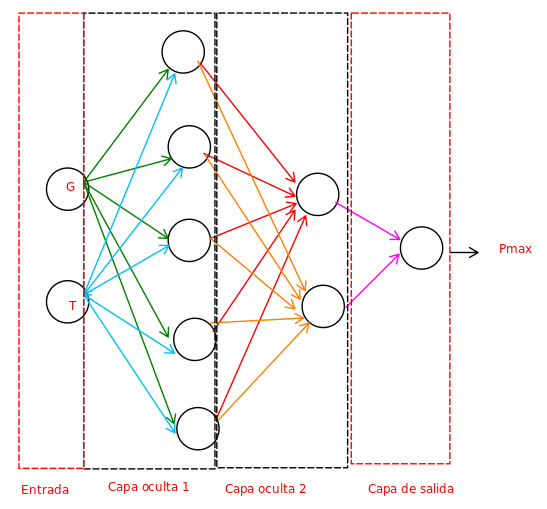

(array([50., 59., 95., 41., 15., 13., 11.,  2.,  1.,  2.]),
 array([6.04573753e-05, 6.09991618e-01, 1.21992278e+00, 1.82985394e+00,
        2.43978510e+00, 3.04971626e+00, 3.65964742e+00, 4.26957858e+00,
        4.87950974e+00, 5.48944090e+00, 6.09937206e+00]),
 <a list of 10 Patch objects>)

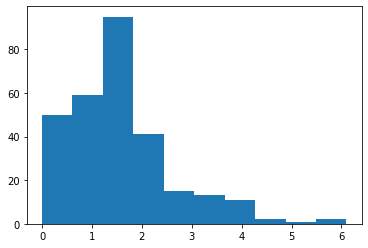

In [ ]:
# Graficamos el error
plt.hist(test_1['Error %'])

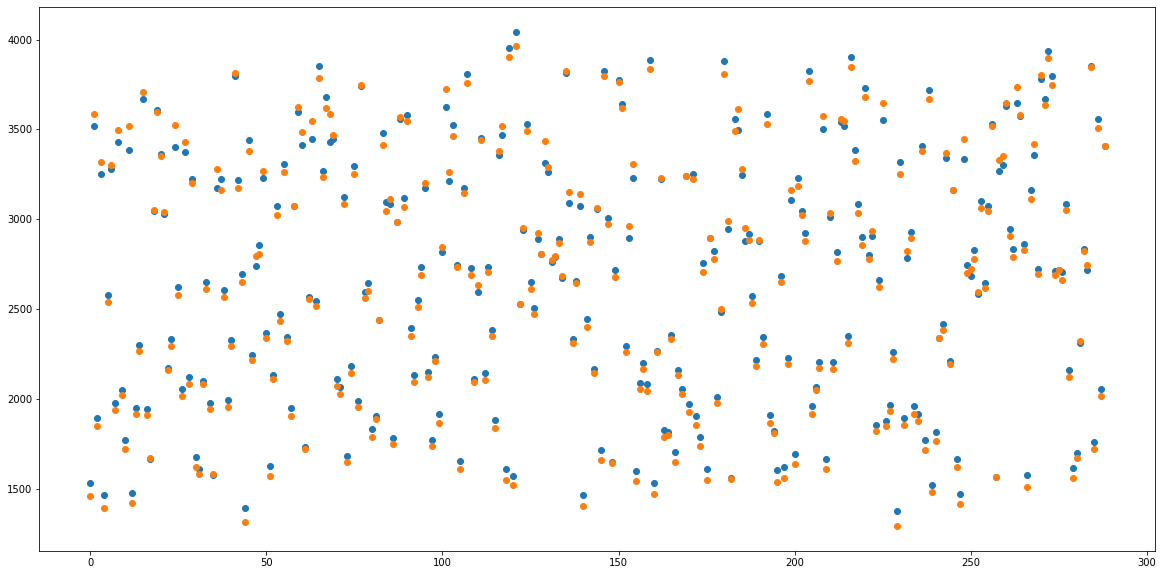

In [ ]:
x = []
for i in range(289):
  x.append(i)

plt.figure(figsize=(20,10))
plt.scatter(x,test_1['Pmax'])
plt.scatter(x,test_1['Pot Pred'])

## Modelo 2 -  Corriente asociada a una tension

### Procesamiento Data

In [14]:
# PROCESAMIENTO DE LOS DATOS
# Cada archivo se convierte en un dataframe, para luego ser concatenado en uno solo
# Tomamos los datos positivos

# Creacion de un dataframe general con la maxima potencia para cada T y G

path = '/content/PV-System/Data_PV/'



lista_df =[]
for t in range(15,45+1):
  for g in range(400,1000+1,20):
    filename = f'OutputPV_T{t}_G{g}.txt'
    df = pd.read_csv(path + filename, header=None)
    encabezado = ["V", "I"]
    df.columns = encabezado
    df['T'] = t
    df['G'] = g
    
    lista_df.append(df)

In [15]:
dataframe_gen = pd.concat(lista_df)
dataframe_gen

,V,I,T,G
0,0,10.768,15,400
1,1,10.766,15,400
2,2,10.765,15,400
3,3,10.763,15,400
4,4,10.761,15,400
...,...,...,...,...
196,196,-39.222,45,1000
197,197,-40.722,45,1000
198,198,-42.229,45,1000
199,199,-43.742,45,1000


In [16]:
# Filtrar las filas cuyos valores de corriente es negativo

filtro = dataframe_gen['I'] > 0
dataframeGen = dataframe_gen[filtro]
dataframeGen

,V,I,T,G
0,0,10.768000,15,400
1,1,10.766000,15,400
2,2,10.765000,15,400
3,3,10.763000,15,400
4,4,10.761000,15,400
...,...,...,...,...
163,163,4.506000,45,1000
164,164,3.412500,45,1000
165,165,2.299500,45,1000
166,166,1.167600,45,1000


In [18]:
# Guardamos el df en csv
dataframeGen.to_csv('Data_gen.csv')

In [19]:
# Extraemos la data de entrenamiento y validacion y se guarda en csv
train_2, test_2 = train_test_split(dataframeGen, test_size = 0.30)
train_2.to_csv('dataEntrGen.csv')
test_2.to_csv('dataValGen.csv')

## Modelos

### RNN1

Comenzando entrenamiento ... 
Modelo entranado!


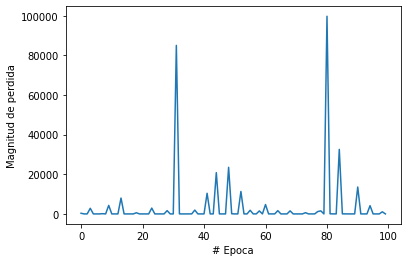

In [24]:
g = train_2['G']
t = train_2['T']
v = train_2['V']

entrada = np.array(np.column_stack((g,t,v)), dtype='float')

i = train_2['I']
salida = np.array(np.transpose(i), dtype='float')
##############################################################


oculta1 = tf.keras.layers.Dense(units=5, input_shape=[3])
oculta2 = tf.keras.layers.Dense(units=3)
oculta3 = tf.keras.layers.Dense(units=2)
output = tf.keras.layers.Dense(units=1)

###############################################################
modelo = tf.keras.Sequential([oculta1,  oculta2, oculta3, output])
###############################################################

modelo.compile(
    optimizer = tf.keras.optimizers.Adam(0.1),
    loss = 'mean_squared_error'
)
###############################################################

print("Comenzando entrenamiento ... ")
historial = modelo.fit(entrada,salida, epochs=100, verbose=False)
print("Modelo entranado!")
###############################################################
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

### RNN 1

Se entrena una red neuronal Densa, la cual recibe como entrada la ```Irradiancia```, la ```Temperatura``` y la ```Tension``` para predecir la ```Corriente```. Se utiliza 3 capas ocultas y 1 capa de salida. Las tres capas ocultas tienen 10 neuronas cada una, y la capa de salida 1 sola neurona. Despues de 2 horas y media de entrenamiento con 1000 epocas se obtuvo el siguiente resultado:

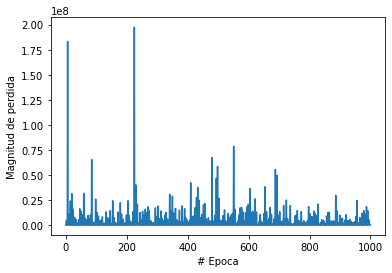

### RNN2

Los resultados no son los mejores ya que existen errores de prediccion muy grandes como podemos ver en el siguiente grafico. 

Ahora se tomaran solamente los valores de corrientes positivas para una segunda prueba.

In [ ]:
# Filtrar las filas cuyos valores de corriente es negativo
filtro = DF['I'] > 0
DF2 = DF[filtro]
DF2

,V,I,P,T,G
0,0,10.768000,0.000000,15,400
1,1,10.766000,10.766000,15,400
2,2,10.765000,21.530000,15,400
3,3,10.763000,32.289000,15,400
4,4,10.761000,43.044000,15,400
...,...,...,...,...,...
163,163,4.506000,734.478000,45,1000
164,164,3.412500,559.650000,45,1000
165,165,2.299500,379.417500,45,1000
166,166,1.167600,193.821600,45,1000


In [ ]:
# Extraemos la data de entrenamiento y validacion y se guarda en csv
train_2, test_2 = train_test_split(DF, test_size = 0.30)

El dataframe general se guarda en un archivo csv de manera local:

```python
DF.to_csv('DataGeneral.csv')
```

Se generan dos dataframes a partir del general: 
* Un dataframe para entrenamiento que consiste en el 70% de los datos totales.
* Un dataframe para valdiacion que corresponde al 30% de los datos totales.

```python
train, test = train_test_split(DF, test_size = 0.30)
```

Ambas datas se guardan de manera local:

```python
train.to_csv("data_entrenamiento.csv")
test.to_csv("data_validacion.csv")
```

Se tiene una red con 3 capas ocultas, la primera tiene 10 neuronas, la segunda 5 neuronas y la tercera 2 neuronas.

In [ ]:
DF2.to_csv('DataFiltro.csv')
train, test = train_test_split(DF2, test_size = 0.30)
train.to_csv("data_entrenamiento_filtro.csv")
test.to_csv("data_validacion_filtro.csv")

In [ ]:
g = train['G']
t = train['T']
v = train['V']
entrada = np.array(np.column_stack((g,t,v)), dtype='float')

i = train['I']
salida = np.array(np.transpose(i), dtype='float')

In [ ]:
oculta1 = tf.keras.layers.Dense(units=10, input_shape=[3])
oculta2 = tf.keras.layers.Dense(units=5)
oculta3 = tf.keras.layers.Dense(units=2)
modelo = tf.keras.Sequential([oculta1,  oculta2, oculta3])

In [ ]:
modelo.compile(
    optimizer = tf.keras.optimizers.Adam(0.1),
    loss = 'mean_squared_error'
)

In [ ]:
print("Comenzando entrettnamiento ... ")
historial = modelo.fit(entrada,salida, epochs=500, verbose=False)
print("Modelo entranado!")

Comenzando entrenamiento ... 
Modelo entranado!


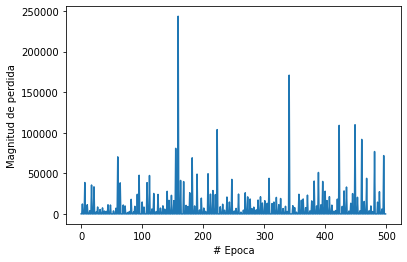

In [ ]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de perdida")
plt.plot(historial.history["loss"])

Los resultados siguen siendo los no esperados